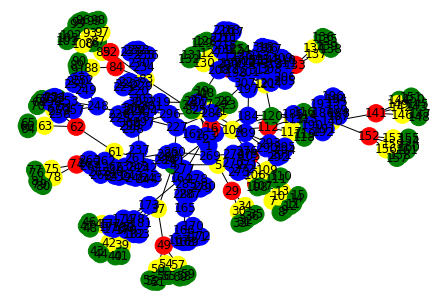

In [16]:
import simpy
import random
import statistics
import networkx as nx  # importing networkx package
import matplotlib.pyplot as plt  # importing matplotlib package and pyplot is for displaying the graph on canvas

NODE_TRAVERSE = 0.2
MAV_THRESHOLD = 5


class Mav(nx.Graph):
    '''

    '''
    def __init__(self, env, entry=8, mav_depth=6, graph_depth=7):
        """ Gráfico MAV simulando a estrutura de vasos sanguíneos no cérebro.

        :param env: Ambiente de simulação
        :param entry: capacidade de vazão do injetro de nanites.
        :param mav_depth: profundidade na rede onde se inicia uma malformção.
        :param graph_depth: profundidade da rede de vasos sanguíneos.
        """
        self.swarm = []
        """Armazena todos os nanites injetados no sangue"""
        self.env = env
        super().__init__()
        self.node_name = 1
        """Inicia a nomeação dos nós com o número 1"""
        self.graph_depth = graph_depth
        self.mav_origin = False
        """Marcador do início da MAV no grafo."""
        self.mav_depth = mav_depth
        self.markers = "blue green yellow red yellow green".split()
        """Nível de concentração dos marcadores de MAV."""
        self.entry_node = None
        """Vaso onde os nanites foram injetados"""
        self.entry_point = simpy.Resource(env, entry)
        """capacidade de vazão da agulha injetora"""
        self.wait_times = []
        """tempos de percurso dos nanites"""

    def do_edge(self, node, depth, mav=0):
        """ Criação de uma aresta representado um vaso sanguíneo

        :param node: O nó, que representa um entrroncamento de vasos.
        :param depth: profundidade corrente, decrementa ao avançar de nível.
        :param mav: determina o nivél de marcadores de mav neste nó
        :return: None
        """
        self.node_name += 1
        mav_depth = self.mav_depth
        name = self.node_name
        self.add_edge(node, name, depth=depth, mav=mav)
        self.nodes[name]['color'] = self.markers[mav]
        depth -= 1
        if (not self.mav_origin) and (depth < mav_depth):
            self.mav_origin = True
            mav = 1
        elif mav and (depth < mav_depth):
            mav += 1
        [self.do_edge(name, depth, mav=mav) for _ in range(0, random.randint(2, 3)) if depth]

    def add_edge(self, ori, dest, depth, mav, **kwargs):
        """Adiciona uma aresta no NetworkX e cria uma classe Node para representar o destino.

        :param ori: Nó de origem.
        :param dest: nò de destino.
        :param depth: Profundidade corrente no grafo arterial.
        :param mav: determina o nivél de marcadores de mav neste nó.
        :param kwargs: Outros parâmetros auxiliares para ajutdar na plotagem.
        :return: None
        """
        env = self.env

        class Node:
            def __init__(self, nome, ndepth, nmav):
                """ Nó construído para suportar o processo de simulação.

                :param nome: Nome deste nó.
                :param ndepth: Profundidade corrente no grafo arterial.
                :param nmav: determina o nivél de marcadores de mav neste nó.
                """
                self.nome, self.dest, self.depth, self.mav, self.embolized = nome, [], ndepth, nmav, 0
                self.cross = 0
                self.flow = simpy.Resource(env, depth)
                """Capacidade de vazão deste nó, indo de grosso calibre a capilar"""

            def add_edge(self, ndest):
                """ Adiciona uma vaso de saída neste entroncamento.

                :param ndest: Nó destino
                :return: None
                """
                self.dest.append(ndest)

            def embolize(self):
                """ Emboliza este nó.

                :return: None
                """
                self.embolized += 1

            def cross_node(self, nanite):
                """ Atravessa um nanite por este nó.

                :param nanite: O nanite transeunte.
                :return: None
                """
                self.cross += 1
                # print("cross_node", nanite.name, self.ori, self.cross)
                yield env.process(nanite.cross_node(self.flow, self, self.dest, self.mav, self.depth))
                yield env.timeout(NODE_TRAVERSE)

        super().add_edge(ori, dest, **kwargs)
        """Usa o add edge herdado do NetworkX"""
        node, ori_node = self.nodes[dest], self.nodes[ori]
        if "node" not in ori_node:
            ori_node["node"] = Node(ori, depth, mav)
        if "node" not in node:
            node["node"] = Node(dest, depth, mav)

        self.nodes[ori]["node"].add_edge(self.nodes[dest]["node"])

    def build(self):
        """Constrói o grafo de maneira aleatória

        :return: None
        """
        self.do_edge(self.node_name, self.graph_depth)
        self.nodes[1]['color'] = "blue"
        self.entry_node = self.nodes[1]['node']

    def plot(self):
        values = [self.nodes[node]["color"] for node in self.nodes()]

        nx.draw(self, with_labels=True, node_color=values)
        #  #draws the networkx graph containing nodes which are declared till before
        plt.show()  # displays the networkx graph on matplotlib canvas

    def go_to_mav(self, nanite):
        """Inicia a travessia de um nanite por dentro da corrente sanguínea.
        """
        arrival_time = self.env.now

        with self.entry_point.request() as request:
            yield request
            # nanite_chip = Nanite(nanite, self.env, self.mav_depth)
            nanite_chip = Nanite(nanite, self.env, MAV_THRESHOLD - random.randint(0, 5))
            self.swarm.append(nanite_chip)
            yield self.env.process(self.entry_node.cross_node(nanite_chip))

        # Moviegoer heads into the theater
        self.wait_times.append(self.env.now - arrival_time)

    def run_embolization(self, inital_nanites=3, nanite_interval=0.05):
        """ Executa o processo de embolização, injetando diversos nanites.

        :param inital_nanites:  Frente inicial de nanites injetados.
        :param nanite_interval: Intervalo para a injeção de um nanite
        :return: None
        """
        for nanite in range(inital_nanites):
            self.env.process(self.go_to_mav(nanite))

        while True:
            yield self.env.timeout(nanite_interval)  # Wait a bit before generating a new person

            nanite += 1
            self.env.process(self.go_to_mav(nanite))

    def get_average_wait_time(self):
        average_wait = statistics.mean(self.wait_times)
        minutes, frac_minutes = divmod(average_wait, 1)
        seconds = frac_minutes * 60
        return round(minutes), round(seconds)

    def count_embolizations(self):
        """ Retorna valores sobre a embolização

        :return: Número de Manites que embolizaram, número de nós embolizados.
        """
        # print(statistics.mean(nano.trs for nano in self.swarm))
        # print(self.entry_node.cross, [[k.ori for k in self.nodes[j]["node"].dest] for j in range(2, 6)])
        # print(self.entry_node.dest)
        return sum(1 for nano in self.swarm if nano.mav), len(self.swarm), sum(
            1 for nd in self.nodes if self.nodes[nd]["node"].embolized > 0
                   )

    def count_mav_rates(self):
        """Retorna estatísticas sobre a MAV embolizada

        :return: Nós embolizados, média de nanites embolizando o mesmo nó.
        """
        return sum(1 for nd in self.nodes if self.nodes[nd]["node"].mav > 0
                   ), statistics.mean(self.nodes[nd]["node"].embolized
                                      for nd in self.nodes if self.nodes[nd]["node"].embolized > 0)


class Nanite:
    def __init__(self, name, env, depth):
        """ O nanochip de embolização. Atualmente tem uma programação aleatória

        :param name: Identificador do chip.
        :param env: Ambiente de simulaçao.
        :param depth: Profundidade programada de embolização.
        """
        self.name, self.depth, self.env = name, depth, env
        self.mav, self.trs = 0, -1
        """Concentração de marcadores onde embolizou, nível de profundidade quando embolizou"""

    def cross_node(self, flow, current_node, destinations, mav, depth):
        """Atravessa um entrocamento de vasos, decidindo a ação a tomar.

        :param flow: capacidade de fluxo onde o nanite se encontra.
        :param current_node: Nó que está atravessando no momento.
        :param destinations: Listra dos possíveis destinos neste entroncamento.
        :param mav: Determina o nível de marcadores de mav neste nó.
        :param depth: Profundidade do nó que está atravessando no momento.
        :return:
        """
        with flow.request() as request:
            yield request
            self.trs = depth
            if (depth <= self.depth) and mav:
                """estando na MAV e profundidade programada, para e emboliza"""
                self.mav = mav
                current_node.embolize()
            elif destinations:
                destination = random.choice(destinations)
                yield self.env.process(destination.cross_node(self))


def main():
    env = simpy.Environment()
    mav = Mav(env=env)
    # random.seed(43)
    mav.build()
    # mav.plot() #descomente esta linha para plotar o grafo

    # Run the simulation
    env.process(mav.run_embolization())
    env.run(until=90)

    # View the results
    mins, secs = mav.get_average_wait_time()
    success, total, embolized = mav.count_embolizations()
    mav_nodes, avg_embol = mav. count_mav_rates()
    print(
      "Running simulation...",
      f"\nThe average wait time is {mins} minutes and {secs} seconds.",
      f"\nThe sucess count is {success} over {total} total, with {embolized} embolized.",
      f"\nThe mav count is {mav_nodes} and over_embolization {avg_embol} average.",
    )


main()
